In [1]:
from astropy.table import Table, vstack, hstack, join
import pickle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import HTML
import imageio
import matplotlib as mpl

In [2]:
def absMagKinda2absMag(absMagKinda):
    """
    convert my funny units of parallax[mas]*10**(0.2*apparent magnitude[mag]) to an absolute magnitude [mag]
    """
    absMagKinda_in_arcseconds = absMagKinda/1e3 #first convert parallax from mas ==> arcseconds
    return 5.*np.log10(10.*absMagKinda_in_arcseconds)

def colorArray(mag1, mag1Array, mag2, mag2Array, dustEBV):
    mag1DustCorrected   = dustCorrect(mag1Array, dustEBV, mag1)
    mag2DustCorrected   = dustCorrect(mag2Array, dustEBV, mag2)
    return mag1DustCorrected - mag2DustCorrected

def dustCorrect(mag, EBV, band):
    """
    using Finkbeiner's dust model, correct the magnitude for dust extinction
    """

    dustCoeff = {'B': 3.626,
                 'V': 2.742,
                 'g': 3.303,
                 'r': 2.285,
                 'i': 1.698,
                 'J': 0.709,
                 'H': 0.449,
                 'K': 0.302,
                 'W1':0.18,
                 'W2':0.16,
                 'G': 2.55}

    return mag - dustCoeff[band]*EBV


In [3]:
cache_file = 'tgas2massunwise.pkl'
with open(cache_file, "rb") as f:
            res = pickle.load(f)

In [4]:
tblphot = Table(res)

In [5]:
cmdPost = np.load('../photoParallax/posteriorParallax.128gauss.dQ0.05.10th.2MASS.All.npz')
dustFile = '../photoParallax/dustCorrection.128gauss.dQ0.05.10th.2MASS.All.npz'
dust = np.load(dustFile)

In [6]:
print(np.sum(dust['sourceID'] == cmdPost['sourceID']), len(dust['sourceID']))
print(dust.keys())
print(cmdPost.keys())

1375083 1375083
['sourceID', 'ebv']
['var', 'sourceID', 'posterior', 'mean']


In [7]:
tblpar = Table([cmdPost['sourceID'], cmdPost['mean'], cmdPost['var'], dust['ebv']], names=['source_id', 'parallax', 'parallax_var', 'EBV'])

In [8]:
print(len(tblphot), len(tblpar))

454061 1375083


In [9]:
del cmdPost
del dust

In [35]:
tbl = join(tblphot, tblpar, keys='source_id', join_type='inner')

In [11]:
tbl.keys()

['treated_as_pointsource',
 'pointsource',
 'w1_mag',
 'w1_mag_err',
 'w2_mag',
 'w2_mag_err',
 'source_id',
 'ra',
 'dec',
 'parallax_1',
 'parallax_error',
 'phot_g_mean_flux',
 'phot_g_mean_flux_error',
 'l',
 'b',
 'j_m',
 'k_m',
 'h_m',
 'j_cmsig',
 'k_cmsig',
 'h_cmsig',
 'parallax_2',
 'parallax_var',
 'EBV']

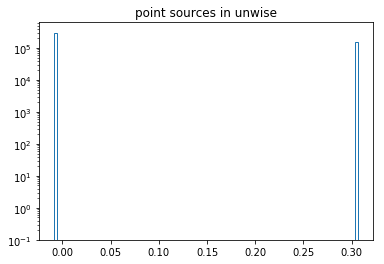

In [12]:
plt.hist(tbl['w1_mag'][tbl['pointsource']] - tbl['w2_mag'][tbl['pointsource']], bins=100, log=True, histtype='step')
plt.title('point sources in unwise')

In [13]:
tbl['pointsource']

0
0
0
0
0
0
0
0
0
0
0


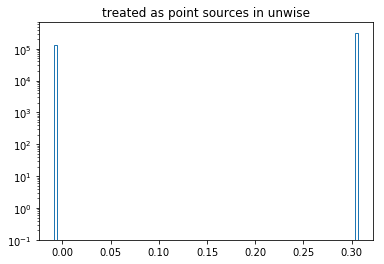

In [14]:
plt.hist(tbl['w1_mag'][tbl['treated_as_pointsource']] - tbl['w2_mag'][tbl['treated_as_pointsource']], bins=100, log=True, histtype='step')
plt.title('treated as point sources in unwise')

In [36]:
good = ~np.isnan(tbl['w2_mag']) & ~np.isnan(tbl['w1_mag']) & ~np.isnan(tbl['parallax_2']) & np.logical_not(tbl['pointsource']) & np.logical_not(tbl['treated_as_pointsource'])
good = np.logical_and(good, tbl['w2_mag_err'] < 0.1)
good = np.logical_and(good, tbl['w1_mag_err'] < 0.1)
good = np.logical_and(good, tbl['parallax_1'] > 0.)
good = np.logical_and(good, tbl['parallax_2'] > 0.)

//anaconda/envs/py36/lib/python3.6/site-packages/astropy/table/column.py:929: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, oper)(other)
//anaconda/envs/py36/lib/python3.6/site-packages/astropy/table/column.py:929: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, oper)(other)


ValueError: operands could not be broadcast together with shapes (452503,) (19363,) 

In [38]:
print(np.sum(~good))
print(np.sum(good))

433293
19210


In [37]:
tbl = tbl[good]

In [39]:
print(np.sum(tbl['pointsource']), np.sum(tbl['treated_as_pointsource']))

0 0


In [40]:
np.min(tbl['pointsource'])

0

In [41]:
#color = colorArray(mag1, mag1array, mag2, mag2array, dustEBV)
#apparentMagnitude = dustCorrect(magArray, dust, magName)
#absMagKinda = mean*10.**(0.2*apparentMagnitude)
#absMag = absMagKinda2absMag(absMagKinda)
tmasscolor = colorArray('J', tbl['j_m'], 'K', tbl['k_m'], tbl['EBV'])
wisecolor = colorArray('W1', tbl['w1_mag'], 'W2', tbl['w2_mag'], tbl['EBV'])
apparentMagnitude = dustCorrect(tbl['j_m'], tbl['EBV'], 'J')
absMagKinda = tbl['parallax_2']*10.**(0.2*apparentMagnitude)
absMagKinda2 = tbl['parallax_1']*10.**(0.2*apparentMagnitude)
absMag = absMagKinda2absMag(absMagKinda)
absMag2 = absMagKinda2absMag(absMagKinda2)

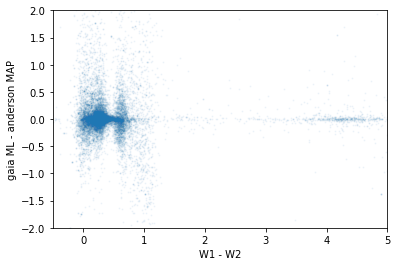

In [52]:
plt.scatter(tmasscolor, absMag - absMag2, s=1, alpha=0.05)
plt.xlim(-0.5, 5)
plt.ylim(-2, 2)
plt.xlabel('W1 - W2')
plt.ylabel('gaia ML - anderson MAP')

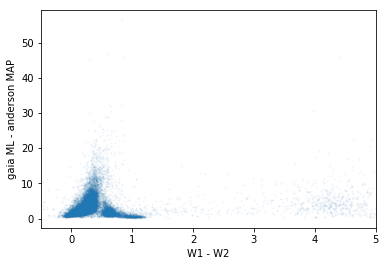

In [55]:
#parallax_1 is gaia ML
plt.scatter(tmasscolor, tbl['parallax_2'], s=1, alpha=0.05)
plt.xlim(-0.5, 5)
#plt.ylim(0, 2)
plt.xlabel('W1 - W2')
plt.ylabel('gaia ML - anderson MAP')

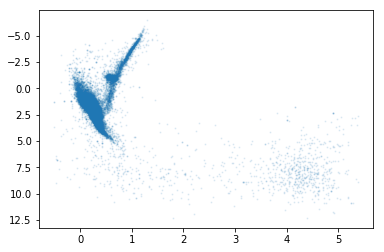

In [43]:
plt.scatter(tmasscolor, absMag, s=1, alpha=0.1)
plt.gca().invert_yaxis()
#plt.xlim(-0.5, 2)
#plt.ylim(6, -6)

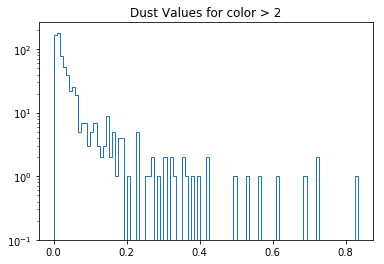

In [44]:
plt.hist(tbl['EBV'][tmasscolor > 2], bins=100, log=True, histtype='step')
plt.title('Dust Values for color > 2')

In [45]:
wiseappmag = dustCorrect(tbl['w2_mag'], tbl['EBV'], 'W2')
wiseabsMagKinda = tbl['parallax_2']*10.**(0.2*wiseappmag)
wiseabsMagKinda2 = tbl['parallax_1']*10.**(0.2*wiseappmag)
wiseabsMag = absMagKinda2absMag(wiseabsMagKinda)
wiseabsMag2 = absMagKinda2absMag(wiseabsMagKinda2)

In [46]:
print(np.max(tbl['parallax_2']))

56.3374889517


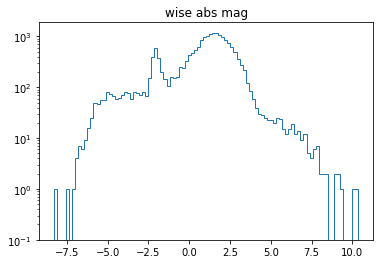

In [47]:
plt.hist(wiseabsMag, bins=100, histtype='step', log=True)
plt.title('wise abs mag')

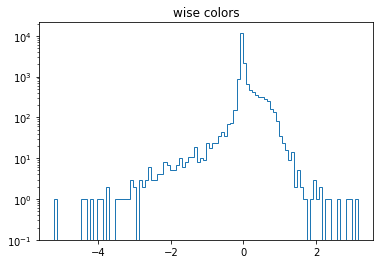

In [48]:
plt.hist(wisecolor[np.logical_not(tbl['pointsource']) & np.logical_not(tbl['treated_as_pointsource'])], bins=100, histtype='step', log=True)
plt.title('wise colors')

15973


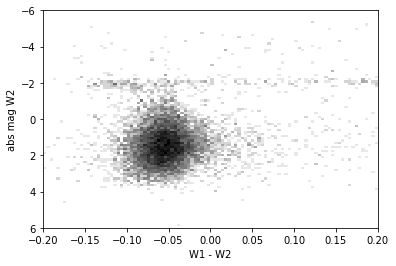

In [49]:
innow = (np.abs(wisecolor) < 0.2) & (np.abs(wiseabsMag) < 6) 
print(np.sum(innow))
plt.hist2d(wisecolor[innow], wiseabsMag[innow], norm=mpl.colors.LogNorm(), bins=100, cmap='Greys')
#plt.gca().invert_yaxis()
plt.xlim(-0.2, 0.2)
plt.ylim(6, -6)
plt.xlabel('W1 - W2')
plt.ylabel('abs mag W2')
plt.savefig('wiseColorMagnitudeDiagram.png')

15973


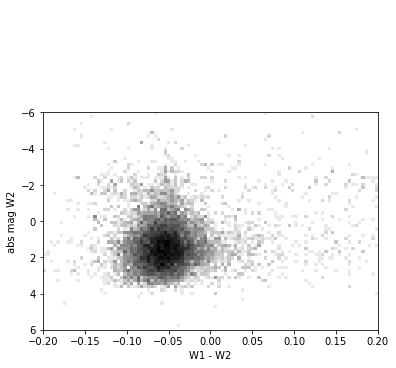

In [50]:
innow = (np.abs(wisecolor) < 0.2) & (np.abs(wiseabsMag) < 6) 
print(np.sum(innow))
plt.hist2d(wisecolor[innow], wiseabsMag2[innow], norm=mpl.colors.LogNorm(), bins=100, cmap='Greys')
#plt.gca().invert_yaxis()
plt.xlim(-0.2, 0.2)
plt.ylim(6, -6)
plt.xlabel('W1 - W2')
plt.ylabel('abs mag W2')
plt.savefig('wiseColorMagnitudeDiagram.png')

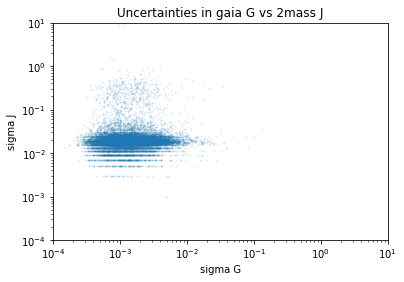

In [186]:
plt.scatter(1.086*(tbl['phot_g_mean_flux_error'])/tbl['phot_g_mean_flux'], tbl['j_cmsig'], s=1, alpha=0.1)
plt.yscale('log')
plt.xscale('log')
plt.xlim(0.0001, 10)
plt.ylim(0.0001, 10)
plt.xlabel('sigma G')
plt.ylabel('sigma J')
plt.title('Uncertainties in gaia G vs 2mass J')

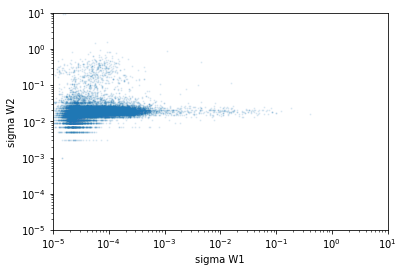

In [187]:
plt.scatter(tbl['w1_mag_err'], tbl['j_cmsig'], s=1, alpha=0.1)
plt.yscale('log')
plt.xscale('log')
plt.xlim(0.00001, 10)
plt.ylim(0.00001, 10)
plt.xlabel('sigma W1')
plt.ylabel('sigma W2')

In [188]:
print(np.sum(tbl['pointsource']))
print(len(tbl))

0
19442


In [191]:
colorMid = 0.625
colorDel = 0.15
colorMin = colorMid - colorDel
colorMax = colorMid + colorDel
absMagMid = -1.0
absMagDel = 0.5
absMagMin = absMagMid - absMagDel
absMagMax = absMagMid + absMagDel


redclump = (tmasscolor < colorMax) & (tmasscolor > colorMin) & (absMag < absMagMax) & (absMag > absMagMin)

rgb = (tmasscolor > 0.5) & (absMag < 3.)
lms = (tmasscolor > 0.5) & (absMag > 3.)
ums = (tmasscolor < 0.5)

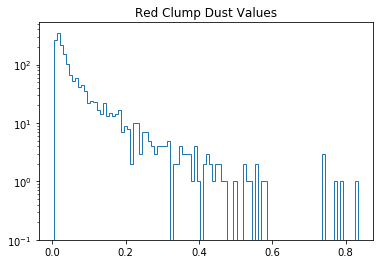

In [192]:
plt.hist(tbl['EBV'][redclump], bins=100, histtype='step', log=True)
plt.title('Red Clump Dust Values')

(4, 20)

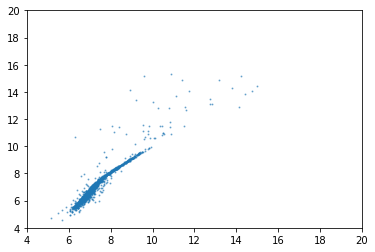

In [193]:
plt.scatter(tbl['w1_mag'][redclump], tbl['w2_mag'][redclump], s=1, alpha=0.5)
plt.xlim(4, 20)
plt.ylim(4, 20)

216
216


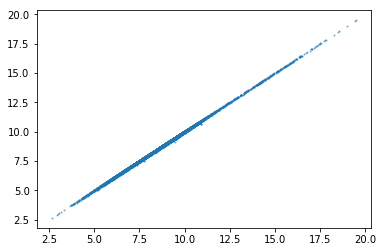

In [195]:
plt.clf()
plt.scatter(tbl['w2_mag'], dustCorrect(tbl['w2_mag'], tbl['EBV'], 'W2'), s=1, alpha=0.5)
#plt.xlim(4, 12)
#plt.ylim(4, 12)
print(np.sum(dustCorrect(tbl['w1_mag'], tbl['EBV'], 'W1') > 12))
print(np.sum(tbl['w1_mag'] > 12))


(array([  1.00000000e+00,   2.00000000e+00,   2.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          5.00000000e+00,   6.00000000e+00,   1.10000000e+01,
          7.00000000e+00,   1.80000000e+01,   2.50000000e+01,
          3.30000000e+01,   3.40000000e+01,   4.10000000e+01,
          6.60000000e+01,   9.10000000e+01,   1.35000000e+02,
          1.65000000e+02,   1.86000000e+02,   2.48000000e+02,
          2.90000000e+02,   3.16000000e+02,   3.55000000e+02,
          3.62000000e+02,   3.77000000e+02,   4.41000000e+02,
          4.40000000e+02,   5.31000000e+02,   5.25000000e+02,
          5.89000000e+02,   7.05000000e+02,   8.10000000e+02,
          8.20000000e+02,   9.16000000e+02,   9.83000000e+02,
          1.01800000e+03,   1.09800000e+03,   1.11900000e+03,
          1.06800000e+03,   1.05300000e+03,   9.31000000e+02,
          8.32000000e+02,   5.89000000e+02,   5.12000000e+02,
          3.68000000e+02,   2.51000000e+02,   2.44000000e+02,
        

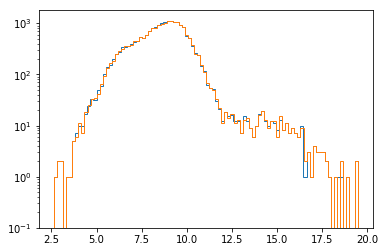

In [196]:
plt.hist(dustCorrect(tbl['w2_mag'], tbl['EBV'], 'W2'), bins=100, histtype='step', log=True)
plt.hist(tbl['w2_mag'], bins=100, histtype='step', log=True)

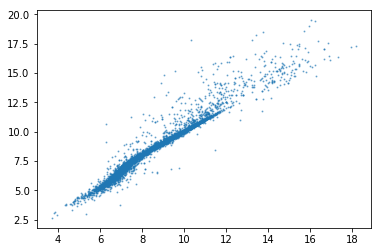

In [197]:
plt.scatter(dustCorrect(tbl['w1_mag'], tbl['EBV'], 'W1'), dustCorrect(tbl['w2_mag'], tbl['EBV'], 'W2'), s=1, alpha=0.5)
#plt.xlim(4, 12)
#plt.ylim(4, 12)

(array([  8.60900000e+03,   3.70800000e+03,   1.71500000e+03,
          1.16200000e+03,   7.43000000e+02,   5.73000000e+02,
          4.81000000e+02,   3.53000000e+02,   3.01000000e+02,
          2.40000000e+02,   2.05000000e+02,   1.76000000e+02,
          1.53000000e+02,   1.22000000e+02,   1.00000000e+02,
          1.13000000e+02,   8.20000000e+01,   9.00000000e+01,
          6.40000000e+01,   5.20000000e+01,   6.00000000e+01,
          5.50000000e+01,   3.40000000e+01,   3.70000000e+01,
          2.50000000e+01,   2.10000000e+01,   1.70000000e+01,
          1.10000000e+01,   1.80000000e+01,   1.10000000e+01,
          1.40000000e+01,   1.00000000e+01,   4.00000000e+00,
          6.00000000e+00,   1.90000000e+01,   6.00000000e+00,
          6.00000000e+00,   2.00000000e+00,   6.00000000e+00,
          8.00000000e+00,   1.00000000e+00,   4.00000000e+00,
          2.00000000e+00,   3.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        

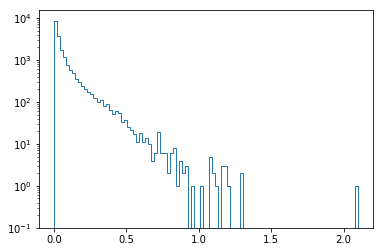

In [198]:
plt.hist(tbl['EBV'], bins=100, histtype='step', log=True)

In [199]:
c1 = '#1f78b4' #'#a6cee3'
c2 = 'black' #'#1f78b4'
c3 = '#b2df8a'
c4 = '#33a02c'

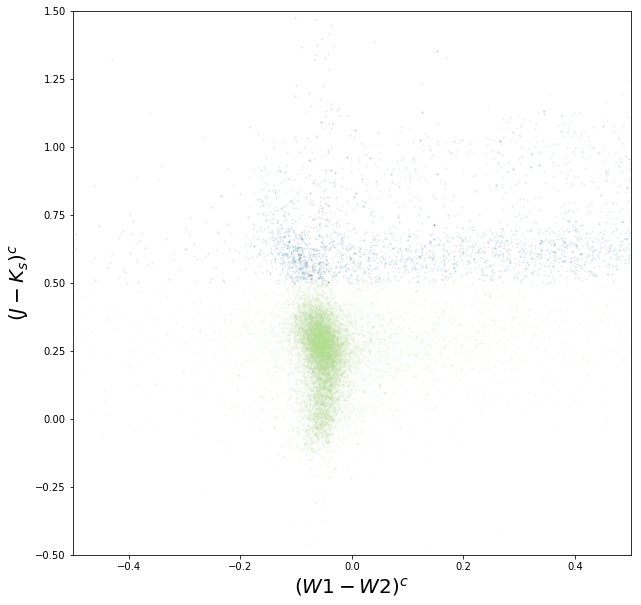

In [201]:
n_frames = 30
n_points = len(tmasscolor)
%matplotlib osx
frames = np.zeros((2,n_points,n_frames))
xlimLoop = np.zeros((2, n_frames))
fig = plt.figure(figsize=(10,10))
#random start and end points to test 
firsty = tmasscolor
firstx = absMag#/-2.5
firstxlim = (-6, 6)
lastxlim = (-0.5, 0.5)

lasty = tmasscolor
#wisecolorChop = wisecolor
#wisecolorChop[wisecolor > ]
lastx = wisecolor

for i in range(n_points):
    frames[0,i,:] = np.linspace(firstx[i],lastx[i],n_frames)
    frames[1,i,:] = np.linspace(firsty[i],lasty[i],n_frames)
xlimLoop[0,:] = np.linspace(firstxlim[0], lastxlim[0], n_frames)
xlimLoop[1,:] = np.linspace(firstxlim[1], lastxlim[1], n_frames)
#make intermediate date points, slow
#frames[0,:,i] = np.linspace(firstx[i],lastx[i],n_frames)
#frames[1,:,i] = np.linspace(firsty[i],lasty[i],n_frames)

#make frames  
for i in range(n_frames):
    fig.clf()
    #plt.figure(figsize=(10,10))
    plt.scatter(frames[0,:,i][rgb], frames[1,:,i][rgb], s=4, lw=0, c=c1, alpha=0.1, zorder=0, rasterized=True)
    plt.scatter(frames[0,:,i][lms], frames[1,:,i][lms], s=4, lw=0, c=c2, alpha=0.1, zorder=1, rasterized=True)
    plt.scatter(frames[0,:,i][ums], frames[1,:,i][ums], s=4, lw=0, c=c3, alpha=0.1, zorder=2, rasterized=True)
    plt.scatter(frames[0,:,i][redclump], frames[1,:,i][redclump], s=1, lw=0, c=c4, alpha=0.1, zorder=3, rasterized=True)

    if i < n_frames/2.: 
        xlabel=r'$M_J^c$'
        ylabel=r'$(J-K_s)^c$'
    else:
        xlabel = r'$(W1 - W2)^c$'
        ylabel = r'$(J-K_s)^c$'
    #plt.scatter(frames[0,:,i],frames[1,:,i],s=1, lw=0, c=c3, alpha=0.1, zorder=2, rasterized=True)
    plt.xlim(xlimLoop[:,i])
    plt.xlabel(xlabel, fontsize=20)
    plt.ylabel(ylabel, fontsize=20)
    plt.ylim(-0.5, 1.5)
    fig.savefig('mlInterp_{0:03d}.png'.format(i))

In [202]:
images = []
#frames = np.arange(0,30)
frames = np.concatenate((np.arange(0, 30), np.zeros(30) + 29))
#addframes = np.zeros(100) + 29

for i in list(frames):
    filename = 'mlInterp_{0}.png'.format('%03d' % i)
    images.append(imageio.imread(filename))
imageio.mimsave('mlInterp10.gif', images)


In [203]:
HTML('<img src="mlInterp10.gif">')